<span style="font-family:Times; font-size:2.5em; ">
        <div class="alert alert-success">
            <span style="color:blue">
               <center>Fun with Cats and Dogs<br><br>
            </span>
         </div>
    </span>

---

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import itertools
import os
import shutil
import random
import glob

from PIL import Image
import PIL

import matplotlib.pyplot as plt
from matplotlib.image import imread
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
tf.__version__

'2.3.1'

### Define use functions
We’re now going to create several functions used in our analysis

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

For these images, the color data was skewed as a result of preprocessing the images using the tf.keras.applications.vgg16.preprocess_input function. The preprocessing that was used on the original training data, and therefore, this is the way we need to process images before passing them to VGG16.

In [5]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [6]:
def plotImages(images_arr,labels_arr):
    i=0
    fig, axes = plt.subplots(4,5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(deprocess_img(img))
        ax.set_title(name(labels_arr[i]),fontsize=22)
        i=i+1
    plt.tight_layout()
    plt.show()

In [7]:
def name (label):
    if label[0]>label[1]:
        return 'Cat ' + str(int(label[0]*1000)/10.0) + '%'
    else:
        return 'Dog ' + str(int(label[1]*1000)/10.0) + '%'

---


In [8]:
working_dir = 'PreBuilt_Data'   

In [9]:
image_names = sorted(os.listdir(os.path.join(working_dir, 'cat')))

print("Number of Cat files: ",len(image_names))
print("First Cat File: ", image_names[0])

Number of Cat files:  500
First Cat File:  cat.5000.jpg


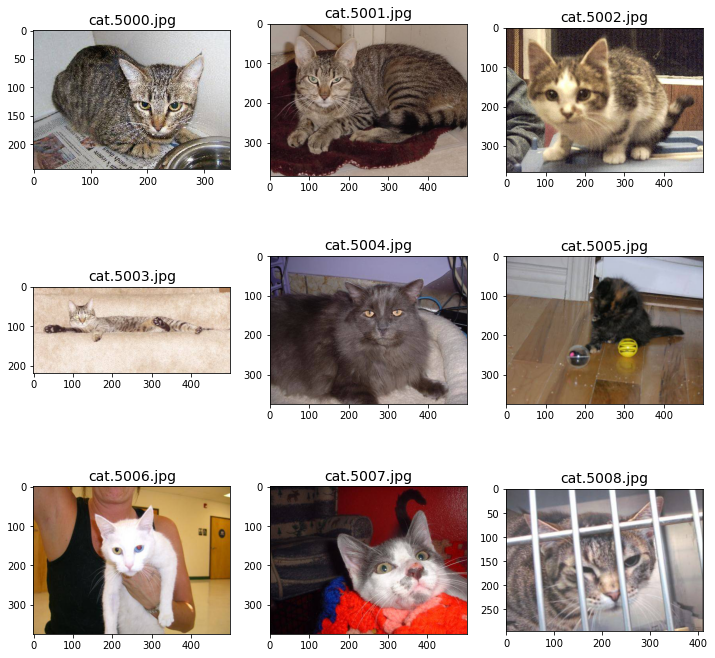

In [10]:
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(330 + 1 + i)
    filename = image_names[i]
    image = imread(os.path.join(working_dir,"cat",image_names[i]))
    plt.imshow(image)
    plt.title(filename,fontsize=14)

plt.show()

In [11]:
image_names = sorted(os.listdir(os.path.join(working_dir, 'dog')))

print("Number of Dog files: ",len(image_names))
print("First Dog File: ", image_names[0])


Number of Dog files:  500
First Dog File:  dog.5000.jpg


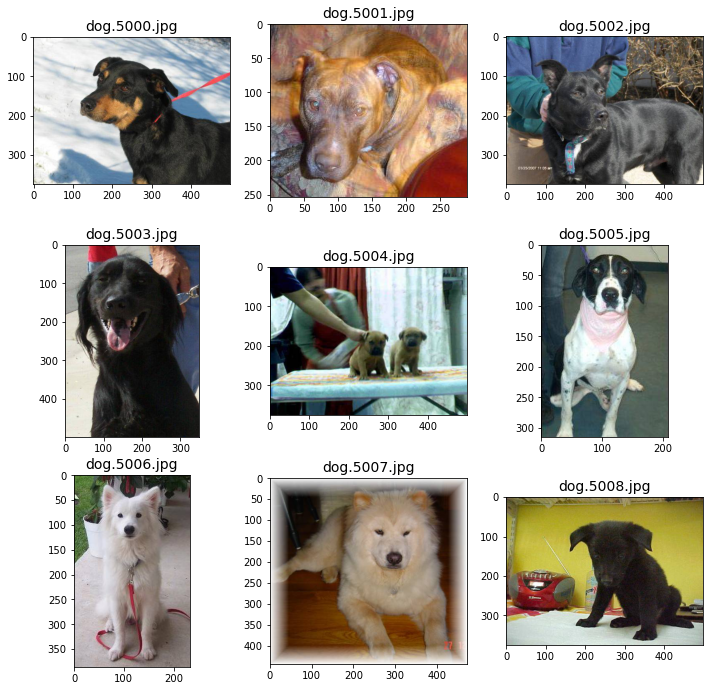

In [12]:
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(330 + 1 + i)
    filename = image_names[i]
    image = imread(os.path.join(working_dir,"dog",image_names[i]))
    plt.imshow(image)
    plt.title(filename,fontsize=14)

plt.show()

---

In [13]:
from tensorflow.keras.models import load_model
new_model = load_model('MLCatsDogPreBuild_model.h5')

In [14]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [15]:
?new_model

In [16]:
new_model.optimizer

In [17]:
new_model.loss

<function tensorflow.python.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0)>

In [18]:
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=working_dir, 
                         target_size=(224,224), 
                         classes=['cat', 'dog'], 
                         batch_size=10, 
                         shuffle=False)

Found 1000 images belonging to 2 classes.


In [19]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [20]:
def plotImages10(images_arr,labels_arr):
    i=0
    fig, axes = plt.subplots(2,5, figsize=(20,10))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(deprocess_img(img))
        ax.set_title(name(labels_arr[i]),fontsize=22)
        i=i+1
    plt.tight_layout()
    plt.show()

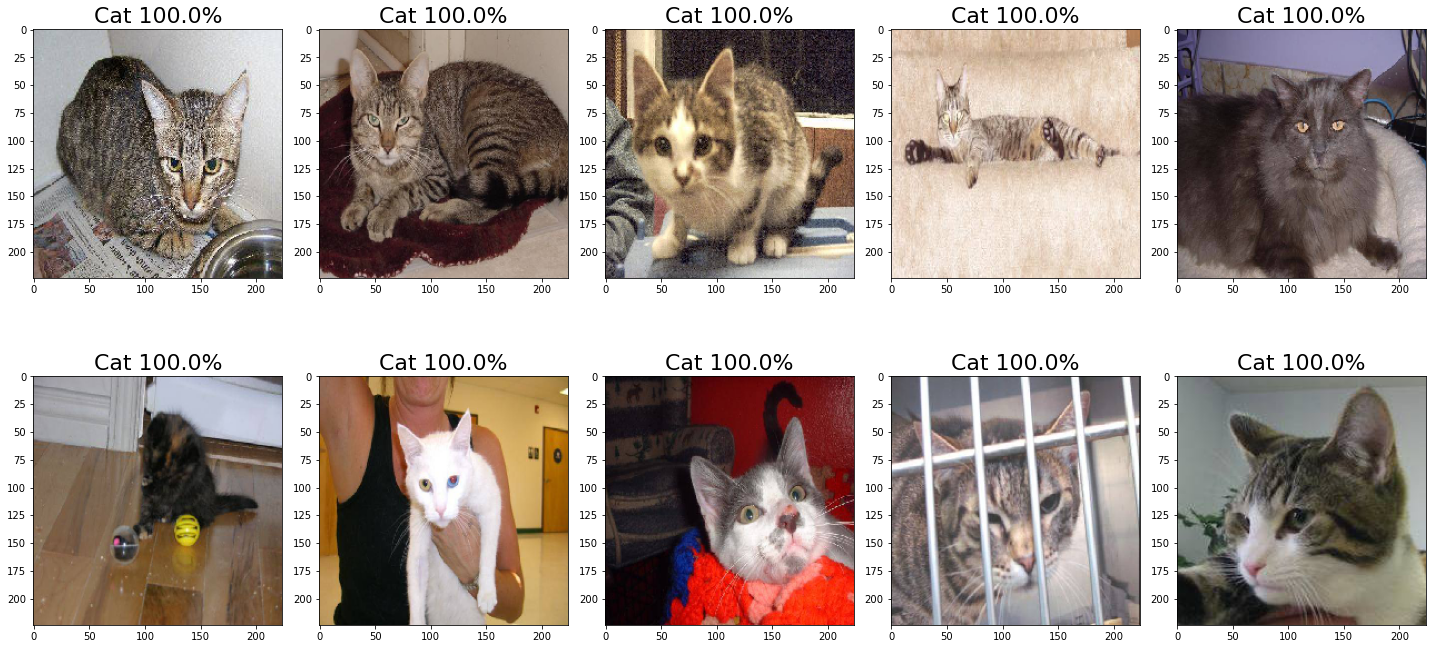

In [21]:
test_imgs, test_labels = next(test_batches)
plotImages10(test_imgs,test_labels)

---

---

In [22]:
%%time

prediction = new_model.predict(x = test_batches, steps = len(test_batches), verbose=1)

100/100 [==============================] - 230s 2s/step
Wall time: 3min 53s


In [23]:
prediction.shape

(1000, 2)

In [24]:
type(prediction)

numpy.ndarray

Plot a confusion matrix to see how well the mode predicts the correct image type, cat or dog

In [25]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(prediction, axis=-1))

In [26]:
cm

array([[499,   1],
       [  1, 499]], dtype=int64)

Confusion matrix, without normalization
[[499   1]
 [  1 499]]


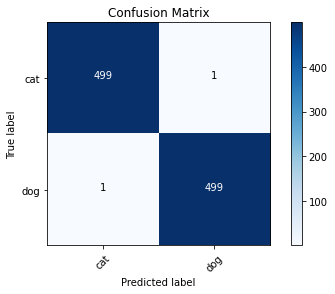

In [27]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

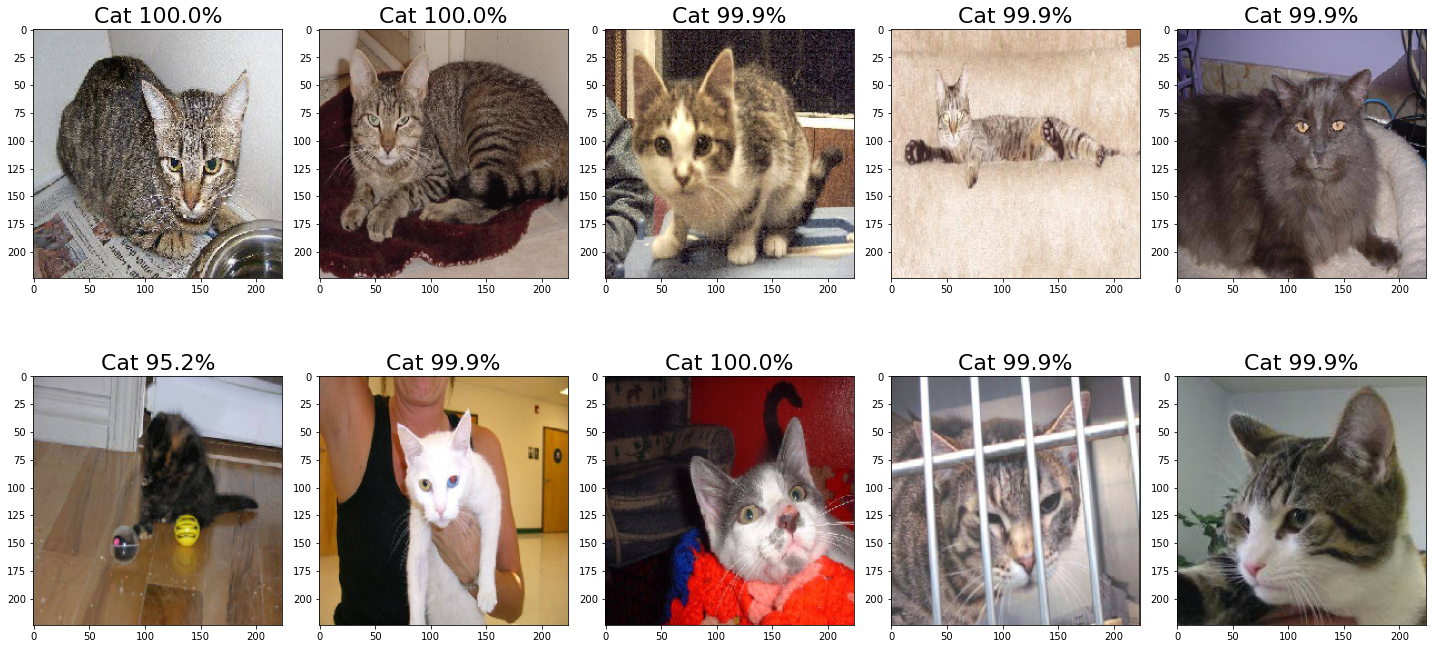

Wall time: 3.23 s


In [28]:
%%time

plotImages10(test_imgs,prediction) 

---

Each time we run the next cell, we will get the next batch of images and see the prediction confidence

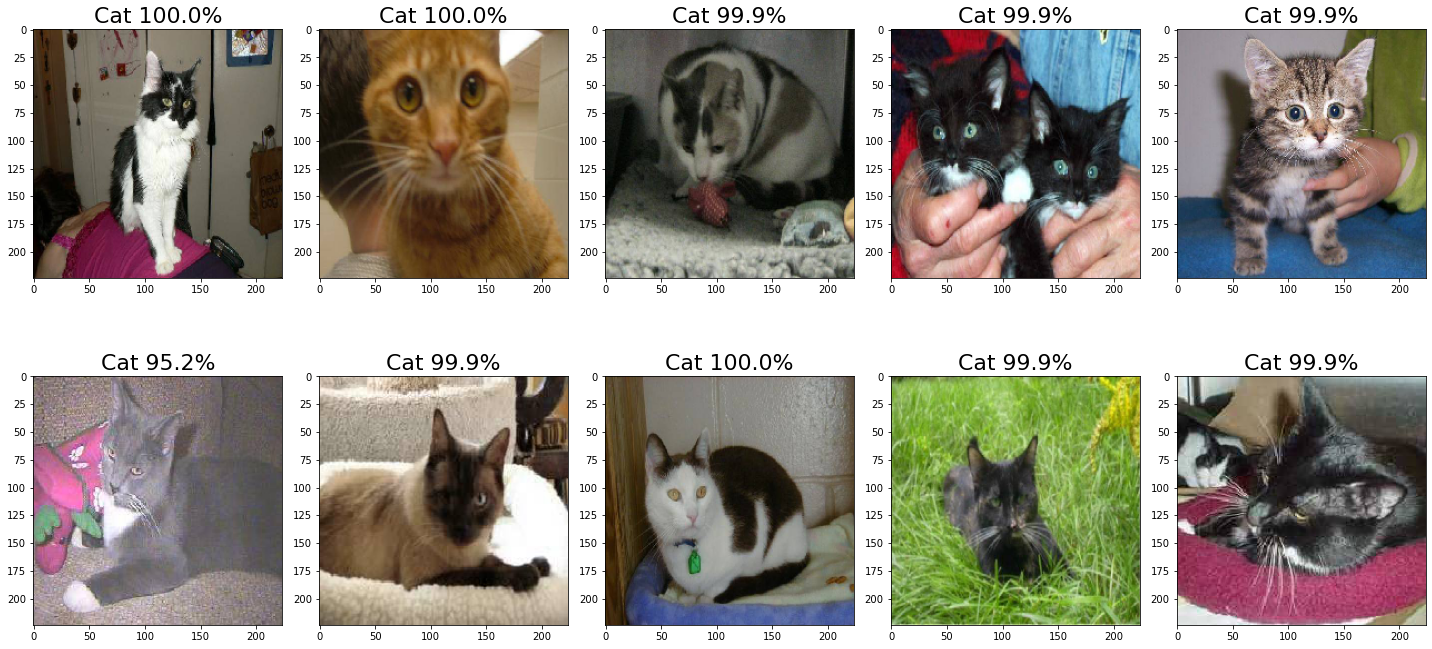

Wall time: 3.36 s


In [29]:
%%time

test_imgs, test_labels = next(test_batches)
plotImages10(test_imgs,prediction)

Confusion matrix, without normalization
[[499   1]
 [  1 499]]


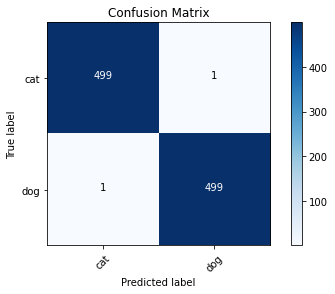

In [30]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [31]:
prediction[368]  

array([0.10815928, 0.8918407 ], dtype=float32)

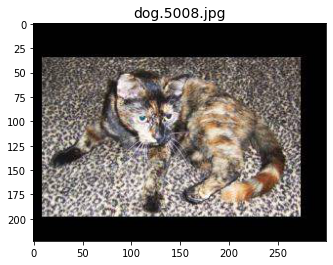

In [32]:
image_names = sorted(os.listdir(os.path.join(working_dir, 'cat')))
i=368
image = imread(os.path.join(working_dir,"cat",image_names[i]))
plt.imshow(image)
plt.title(filename,fontsize=14)
plt.show()

In [33]:
prediction[817]  

array([0.5802978 , 0.41970214], dtype=float32)

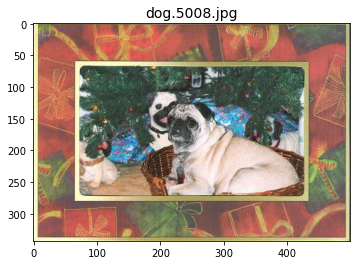

In [34]:
image_names = sorted(os.listdir(os.path.join(working_dir, 'dog')))
i=817-500    
plt.imshow(image)
plt.title(filename,fontsize=14)
plt.show()

---

In [83]:
working_dir = 'My_Pics'

In [84]:
my_pics = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=working_dir, 
                         target_size=(500,500), 
                         classes=['cat', 'dog'], 
                         batch_size=10,              
                         shuffle=False)

Found 10 images belonging to 2 classes.


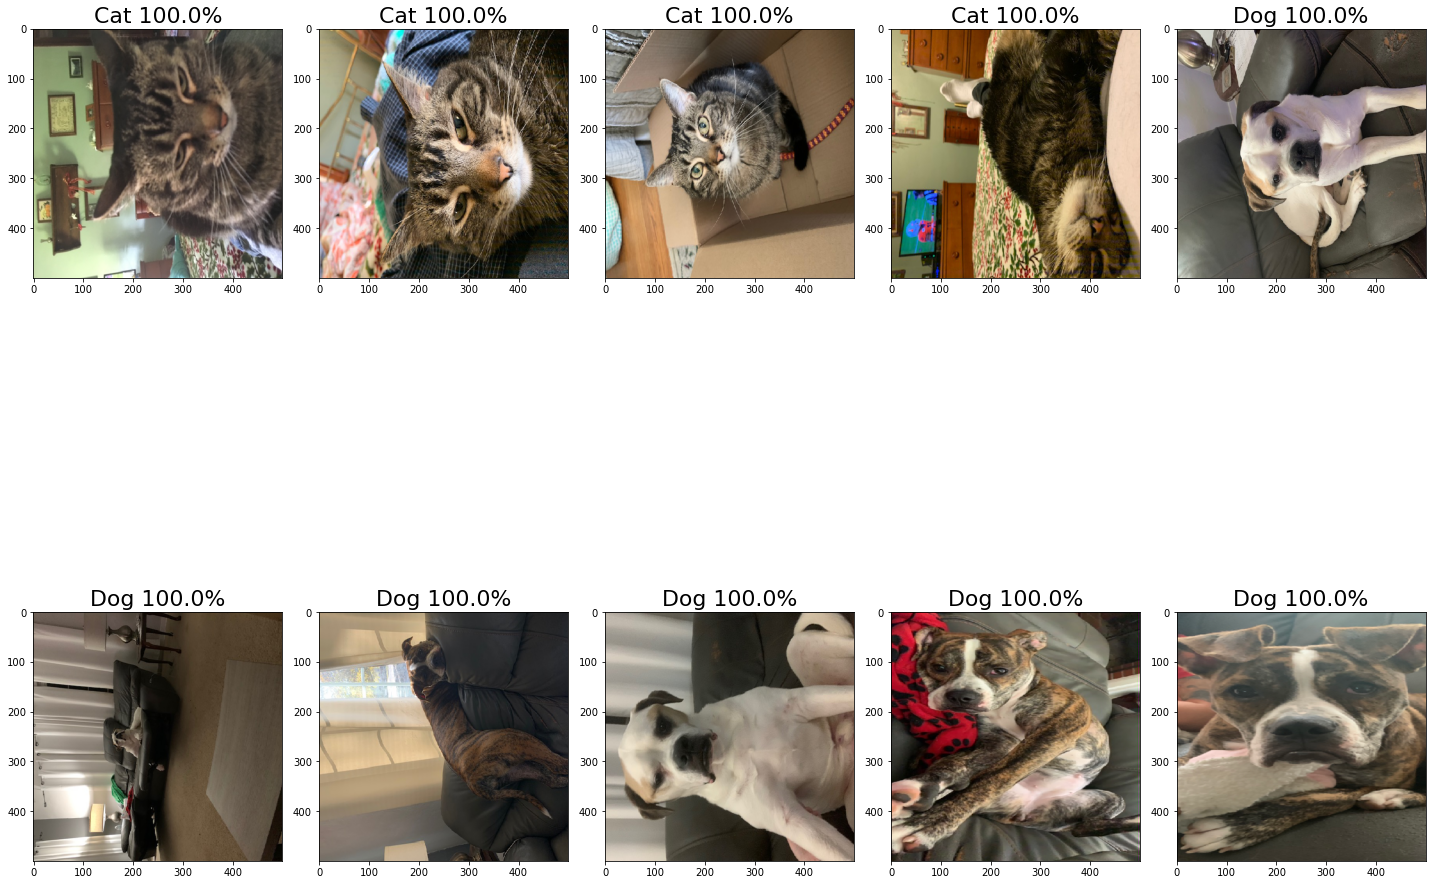

In [86]:
test_imgs, test_labels = next(my_pics)
plotImages10(test_imgs,test_labels)

## Predict the class (dog or cat) from the image!
Now see how to use the fine-tuned VGG16 model that we loaded above to predict on images of cats and dogs in our test set.

In [67]:
%%time

prediction = new_model.predict(x = my_pics, steps = len(my_pics), verbose=1)

1/1 [==============================] - 0s 1ms/step
Wall time: 2.74 s


In [68]:
len(prediction)

10

In [69]:
prediction

array([[9.9999952e-01, 5.0271092e-07],
       [9.9998617e-01, 1.3783819e-05],
       [9.9999905e-01, 9.3966196e-07],
       [9.9996734e-01, 3.2613600e-05],
       [5.1503921e-06, 9.9999487e-01],
       [2.2485317e-01, 7.7514684e-01],
       [7.9845339e-03, 9.9201548e-01],
       [9.8914327e-04, 9.9901080e-01],
       [3.9265482e-04, 9.9960738e-01],
       [2.8820559e-06, 9.9999714e-01]], dtype=float32)

In [70]:
cm = confusion_matrix(y_true=my_pics.classes, y_pred=np.argmax(prediction, axis=-1))

In [71]:
cm

array([[4, 0],
       [0, 6]], dtype=int64)

Confusion matrix, without normalization
[[4 0]
 [0 6]]


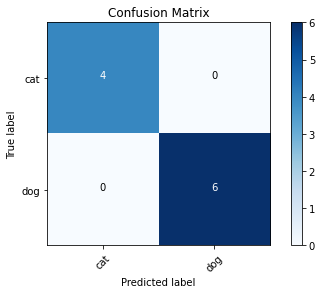

In [72]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

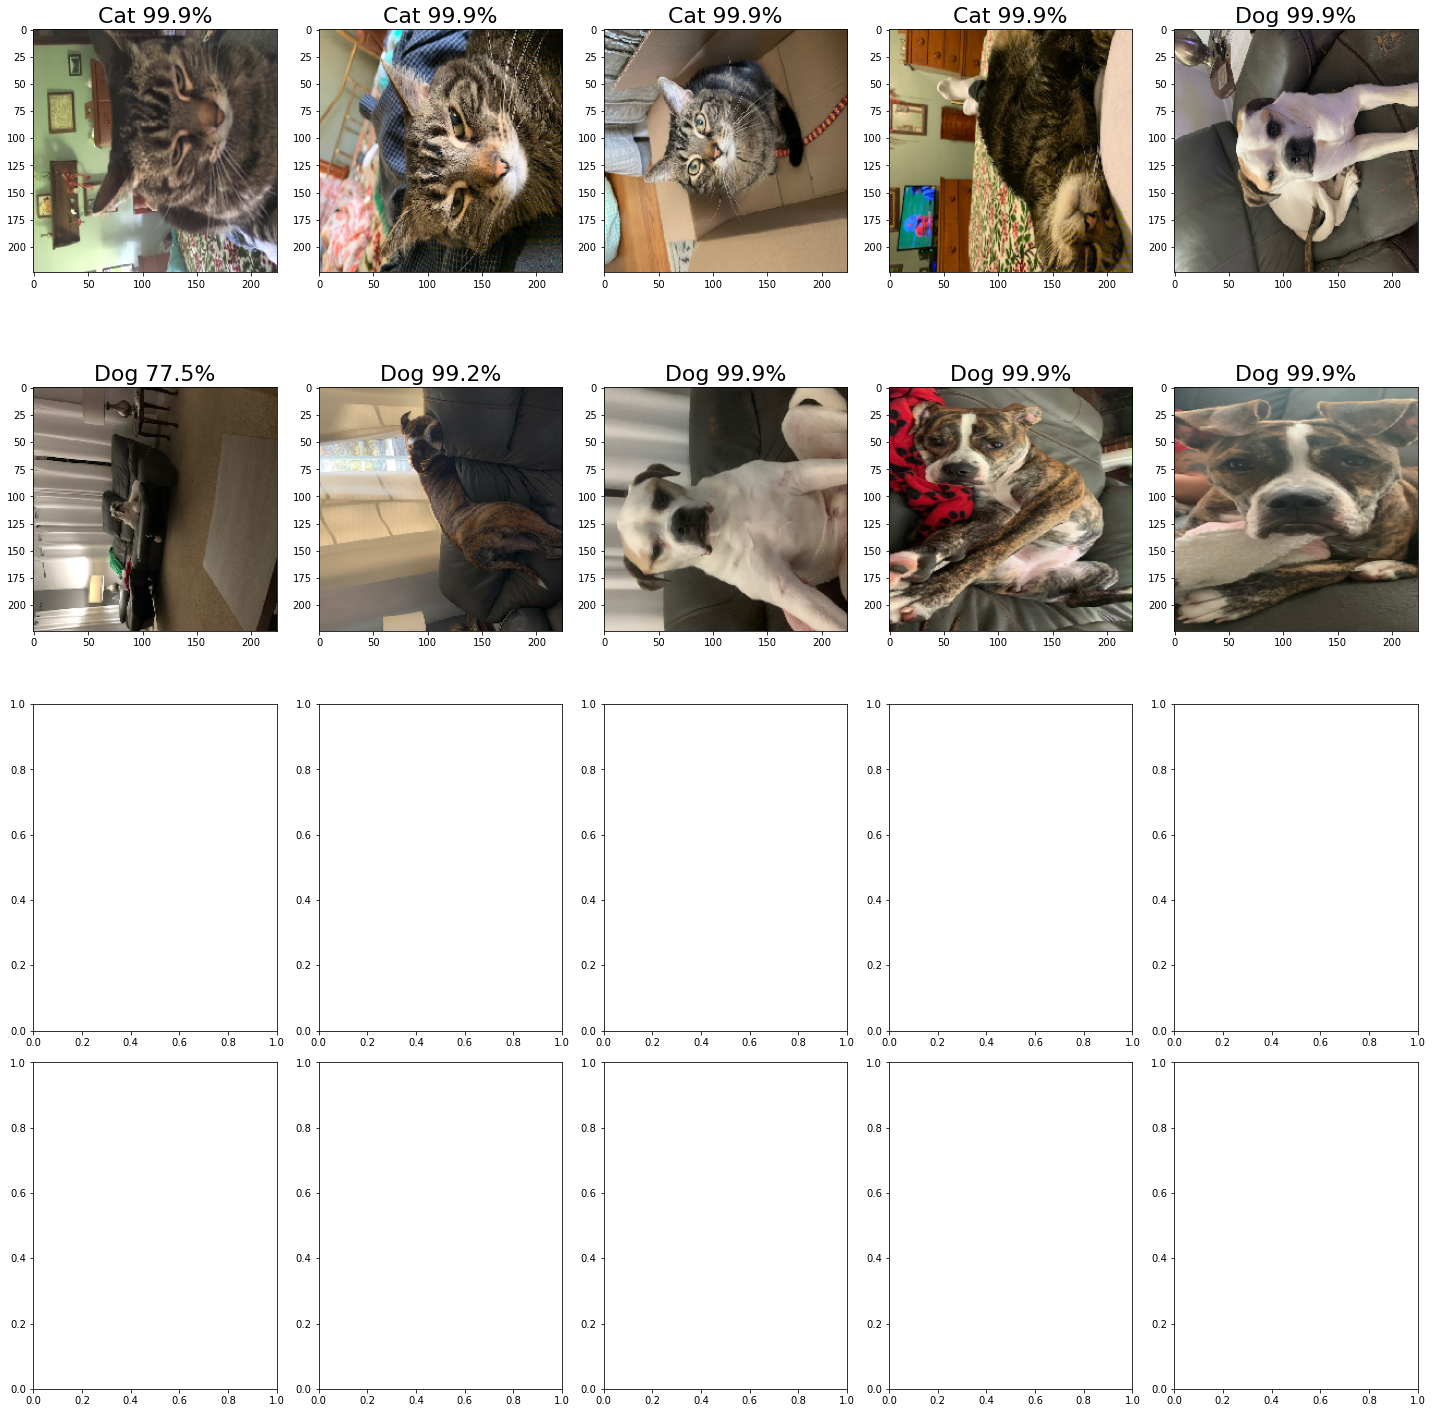

In [73]:
test_imgs, test_labels = next(my_pics)
plotImages20(test_imgs,prediction)


---

In [47]:
%reload_ext version_information

%version_information numpy, tensorflow, sklearn, matplotlib

Software versions
Python 3.7.3 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.8.0
OS Darwin 17.7.0 x86_64 i386 64bit
numpy 1.18.5
tensorflow 2.3.0
sklearn 0.21.1
matplotlib 3.0.3
Sat Dec 05 18:58:11 2020 CST

---